In [164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [165]:
# showing all columns
pd.set_option('display.max_columns', None)
from sklearn.datasets import load_iris
iris = load_iris()
# print(iris)

In [166]:
iris_df = pd.DataFrame(data = iris['data'], columns = iris['feature_names'])
# print(iris_df.to_markdown())
# iris_df.describe()

In [167]:
from sklearn.utils import shuffle
X, y = iris.data, iris.target
# Combine the data and target arrays
combined = list(zip(X,y))
# Shuffle the combined list
shuffled_data = shuffle(combined,random_state=0)

# Unzip the shuffled data
X,y = zip(*shuffled_data)

# Convert back to numpy arrays
X = np.array(X)
y = np.array(y)

In [168]:
import numpy as np

class NB_CLS:
    def __init__(self, num_bins=3):
        self.num_bins = num_bins
        self.prior_probs = None
        self.cond_probs = None

    def preprocess_data(self, X):
        # Divide each attribute value into equally wide bins
        bins = np.linspace(X.min(), X.max(), self.num_bins + 1)
        digitized = np.digitize(X, bins)
        digitized = np.clip(digitized, 1, self.num_bins)
        return digitized

    def compute_prior_probs(self, y):
        # Compute the prior probabilities of each class
        unique_classes, class_counts = np.unique(y, return_counts=True)
        prior_probs = class_counts / len(y)
        return prior_probs

    def compute_cond_probs(self, X, y):
        # Compute the conditional probabilities of each attribute given the class
        num_classes = len(np.unique(y))
        num_features = X.shape[1]
        cond_probs = np.zeros((num_classes, num_features, self.num_bins))

        for c in range(num_classes):
            for f in range(num_features):
                for b in range(self.num_bins):
                    # Count occurrences of feature values in the bin for class c
                    count = np.sum((X[:, f] == b + 1) & (y == c))
                    # Compute conditional probability
                    cond_probs[c, f, b] = count / np.sum(y == c)

        return cond_probs

    def fit(self, X, y):
        # Preprocess data
        X_binned = self.preprocess_data(X)
        
        # Compute prior probabilities
        self.prior_probs = self.compute_prior_probs(y)
        
        # Compute conditional probabilities
        self.cond_probs = self.compute_cond_probs(X_binned, y)

    def predict(self, X):
        # Preprocess data
        X_binned = self.preprocess_data(X)
        
        # Initialize array to store predictions
        predictions = np.zeros(len(X))
        
        # Loop over instances
        for i, x in enumerate(X_binned):
            # Initialize array to store class probabilities
            class_probs = np.zeros(len(self.prior_probs))
            
            # Loop over classes
            for c in range(len(self.prior_probs)):
                # Compute class probability using Naive Bayes formula
                class_probs[c] = self.prior_probs[c]
                for f, b in enumerate(x):
                    class_probs[c] *= self.cond_probs[c, f, b -1]
            
            # Assign instance to class with highest probability
            predictions[i] = np.argmax(class_probs)
        
        return predictions

    def accuracy(self, y_true, y_pred):
        # Compute percentage accuracy
        return np.mean(y_true == y_pred) * 100


In [169]:
from sklearn.model_selection import train_test_split
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate and train the Naive Bayes classifier
nb_classifier = NB_CLS(num_bins=3)
nb_classifier.fit(X_train, y_train)

# Predict classes
y_pred = nb_classifier.predict(X_test)

# Calculate accuracy
accuracy = nb_classifier.accuracy(y_test, y_pred)
print("Percentage Accuracy:", accuracy)


Percentage Accuracy: 96.66666666666667


Percentage Accuracy on K=2 is: 66.66666666666666
Percentage Accuracy on K=3 is: 96.66666666666667
Percentage Accuracy on K=5 is: 86.66666666666667


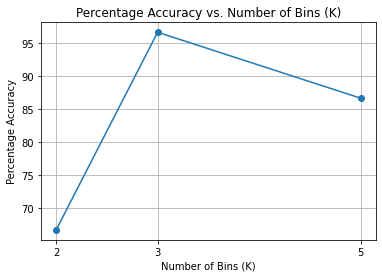

Best value of K: 3
Best Percentage Accuracy: 96.66666666666667


In [170]:
K_values = [2, 3, 5]

# Initialize lists to store accuracy for each K value
accuracy_scores = []

# Iterate over each K value
for K in K_values:
    # Train the Naive Bayes classifier
    nb_classifier = NB_CLS(num_bins=K)
    nb_classifier.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = nb_classifier.predict(X_test)

    # Calculate accuracy and store it
    # Calculate accuracy
    accuracy = nb_classifier.accuracy(y_test, y_pred)
    print(f"Percentage Accuracy on K={K} is:", accuracy)
    accuracy_scores.append(accuracy)

# Plot Percentage Accuracy vs. K
plt.plot(K_values, accuracy_scores, marker='o')
plt.title('Percentage Accuracy vs. Number of Bins (K)')
plt.xlabel('Number of Bins (K)')
plt.ylabel('Percentage Accuracy')
plt.xticks(K_values)
plt.grid(True)
plt.show()

# Find the best value of the hyperparameter K
opt_K = K_values[np.argmax(accuracy_scores)]
best_accuracy = max(accuracy_scores)
print("Best value of K:", opt_K)
print("Best Percentage Accuracy:", best_accuracy)

In [174]:
np.random.seed(0)
# Define the fractions of training data for noise addition
noise_fractions = [0.1, 0.4, 0.8, 0.9]

# Define standard deviation for noise
std_dev = 2.0

# Initialize lists to store accuracy for each noise fraction
accuracy_scores_with_noise = []

# Iterate over each noise fraction
for noise_fraction in noise_fractions:
    # Add noise to a fraction of the training data
    num_samples = int(noise_fraction * len(X_train))
    noise = np.random.normal(loc=0, scale=std_dev, size=(num_samples, X_train.shape[1]))
    X_train_with_noise = np.copy(X_train)
    X_train_with_noise[:num_samples] += noise

    # Train the Naive Bayes classifier with the optimal K
    nb_classifier = NB_CLS(num_bins=opt_K)
    nb_classifier.fit(X_train_with_noise, y_train)

    # Make predictions on the test data
    y_pred = nb_classifier.predict(X_test)

    # Calculate accuracy and store it
    accuracy_with_noise = nb_classifier.accuracy(y_test, y_pred)
    accuracy_scores_with_noise.append(accuracy_with_noise)
    
# Calculate accuracy for the noiseless case (Experiment 1)
nb_classifier_noiseless = NB_CLS(num_bins=opt_K)
nb_classifier_noiseless.fit(X_train, y_train)
y_pred_noiseless = nb_classifier_noiseless.predict(X_test)
accuracy_noiseless = nb_classifier.accuracy(y_test, y_pred_noiseless)

# Print the accuracy for the noiseless case
print("Accuracy for noiseless case (Experiment 1):", accuracy_noiseless)
# Print the accuracy for each noise fraction
for i, noise_fraction in enumerate(noise_fractions):
    print("Accuracy with noise fraction {:.0f}%:".format(noise_fraction * 100), accuracy_scores_with_noise[i])

Accuracy for noiseless case (Experiment 1): 96.66666666666667
Accuracy with noise fraction 10%: 50.0
Accuracy with noise fraction 40%: 63.33333333333333
Accuracy with noise fraction 80%: 66.66666666666666
Accuracy with noise fraction 90%: 70.0
